# Corner Point Solution
## 19-13

In [4]:
#!/usr/bin/env python3
try: 
    %reload_ext autoreload
except:
    %load_ext autoreload
%autoreload 2
%run basic_material

from pyomo.environ import *
from pyomo.dae import *
from pyomo.opt import SolverStatus, TerminationCondition
import random

Running Python: 3.8.16


In [9]:
T      = 1                            #Maximum time for each stage of the model
STAGES = 2                             #Number of stages
tf = 3
x0 = 0
xn = 2
xf = 1
umax = 1
m        = ConcreteModel()             #Model
m.t      = ContinuousSet(bounds=(0,T)) #Time variable
m.stages = RangeSet(0, STAGES-1)         #Stages in the range [0,STAGES]. Can be thought of as an integer-valued set

m.x  = Var(m.stages, m.t)               #State variable defined for all stages and times
m.dx = DerivativeVar(m.x, wrt=m.t)      #First derivative of state variable with respect to time
m.u  = Var(m.stages, m.t, bounds=(-umax,umax)) #Control variable defined for all stages and times. Bounded to range [0,1]
m.T = Var(m.stages,bounds=(0,tf))
m.x[0,0].fix(x0)
m.x[0,1].fix(xn)
m.x[1,0].fix(xn)
m.x[1,1].fix(xf)

#Setting the value of the derivative.
def eq_dx(m,stage,t):                           #m argument supplied when function is called. `stage` and `t` are given values from m.stages and m.t (see below)
    return m.dx[stage,t] == m.u[stage,t]*m.T[stage]   #Derivative is proportional to the control variable
m.eq_dx = Constraint(m.stages, m.t, rule=eq_dx) #Call constraint function eq_da for each unique value of m.stages and m.t

#We need to connect the different stages together...
def eq_stage_continuity(m,stage):
    if stage==m.stages.last():                    #The last stage doesn't connect to anything
        return Constraint.Skip                      #So skip this constraint
    else:                                         
        return m.x[stage,1]==m.x[stage+1,0]         #Final time of each stage connects with the initial time of the following stage
m.eq_stage_continuity = Constraint(m.stages, rule=eq_stage_continuity)

m.path_v3 = Constraint(m.t, rule=lambda m, t: m.T[0]+m.T[1] == tf)

m.integral0 = Integral(m.t, wrt=m.t, rule=lambda m, t: m.T[0]*sqrt(1+m.u[0,t]**2))
m.integral1 = Integral(m.t, wrt=m.t, rule=lambda m, t: m.T[1]*sqrt(1+m.u[1,t]**2))

#Objective function: maximize `a` at the end of the final stage
m.obj = Objective(expr=m.integral0 + m.integral1, sense=minimize)

#Get a discretizer
discretizer = TransformationFactory('dae.collocation')

#Disrectize the model
#nfe (number of finite elements)
#ncp (number of collocation points within finite element)
#discretizer.apply_to(m,nfe=30,ncp=6,scheme='LAGRANGE-RADAU')
TransformationFactory('dae.finite_difference').apply_to(m, wrt=m.t, nfe=200)

#Get a solver
solver = SolverFactory('ipopt', keepfiles=True, log_file='/z/log', soln_file='/z/sol')
solver.options['max_iter']           = 100000
solver.options['print_level']        = 1
#solver.options['linear_solver']      = 'ma97'
solver.options['halt_on_ampl_error'] = 'yes'

#Solve the model
results = solver.solve(m, tee=True)

print(results.solver.status)
print(results.solver.termination_condition)

Ipopt 3.13.4: max_iter=100000
print_level=1
halt_on_ampl_error=yes


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

ok
optimal


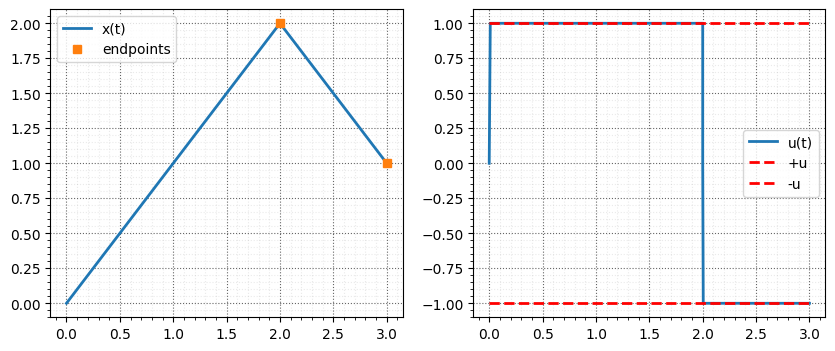

In [10]:
if results.solver.termination_condition == 'optimal':
    tart=value(m.T[:])
    tart.insert(0,0)
    start = np.cumsum(tart)
    r_t = [t*value(m.T[s]) + start[s] for s in sorted(m.stages) for t in sorted(m.t)]
    r_a = [value(m.x[s,t]) for s in sorted(m.stages) for t in sorted(m.t)]
    r_u = [value(m.u[s,t]) for s in sorted(m.stages) for t in sorted(m.t)]

    endpts = [value(m.x[s,1]) for s in sorted(m.stages)]

    plt.figure(1,figsize=(10,4))
    ax1 = plt.subplot(121)
    ax1.plot(r_t, r_a, label="x(t)")
    ax1.plot(start[1:], endpts, 's', label="endpoints")
    plt.legend(loc='best')
    nicegrid()
    ax2 = plt.subplot(122)
    ax2.plot(r_t, r_u, label="u(t)")
    ax2.plot([0,tf], [r_u[2], r_u[2]], 'r--', label="+u")
    ax2.plot([0,tf], [-r_u[2], -r_u[2]], 'r--', label="-u")
    plt.legend(loc='best')
    nicegrid()
    plt.savefig("figs/PointConst.png")
    plt.show()